In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Full imports
import torch
from blockgen.configs import VoxelConfig, DiffusionConfig
from blockgen.utils import create_model_and_trainer, create_dataloaders
from blockgen.inference import DiffusionInference3D
from scripts.generate import load_model_for_inference

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [8]:
# Configs
shape_voxel_config = VoxelConfig(
        mode='two_stage',
        stage='shape',
        default_color=[0.5, 0.5, 0.5],
        alpha_weight=1.0,
        rgb_weight=1.0
    )

color_voxel_config = VoxelConfig(
        mode='two_stage',
        stage='color',
        default_color=[0.5, 0.5, 0.5],
        alpha_weight=1.0,
        rgb_weight=1.0
    )

shape_diffusion_config = DiffusionConfig(
        num_timesteps=1000,
        use_ema=True,  # Enable EMA
        ema_decay=0.9999,
        ema_update_after_step=0,
        ema_device=device,
        use_ddim=False, 
        seed=42  # Set seed for reproducibility
    )

color_diffusion_config = DiffusionConfig(
        num_timesteps=1000,
        use_ema=True,  # Enable EMA
        ema_decay=0.9999,
        ema_update_after_step=0,
        ema_device=device,
        use_ddim=False, 
        seed=42  # Set seed for reproducibility
    )

In [ ]:
# Create model and trainer
trainer, model = create_model_and_trainer(
    voxel_config=voxel_config,
    diffusion_config=diffusion_config,
    resolution=32,
    device=device
)

In [ ]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=diffusion_config,
    config_voxel=voxel_config,
    batch_size=3
)

In [ ]:
metrics = trainer.train(
    train_loader,
    test_loader,
    total_steps=60_000,
    save_every=5_000,
    eval_every=10_000,
    save_dir='runs/experiment_color_60k',
    checkpoint_path='/scratch/students/2024-fall-sp-pabdel/3D-BlockGen/runs/experiment_color_60k/checkpoints/checkpoint_step_50000.pth'
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_losses'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['test_steps'], metrics['test_losses'])
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [1]:
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install iopath
!pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#print(f"pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html")

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=e86a05f43ba21559311f991a2e56b8723da1bd0a119541e371ac5d49121b38d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-6mp17wep/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt201/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 129.6 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [20]:
shape_model = load_model_for_inference(
        model_path="runs/finetune/shape/models/model_step_135000",
        voxel_config=shape_voxel_config,
        diffusion_config=shape_diffusion_config,
        device='cuda',
        ema=True
    )

color_model = load_model_for_inference(
        model_path="runs/experiment_two_stage/color/models/model_step_110000",
        voxel_config=color_voxel_config,
        diffusion_config=color_diffusion_config,
        device='cuda',
        ema=True
    )

The number of input channels is: 1 The number of out channels is1


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 11000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Total parameters: 120096449
Loaded EMA model weights
The number of input channels is: 4 The number of out channels is3


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 110000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Total parameters: 120099331
Loaded EMA model weights


In [21]:
# Inference
inferencer = DiffusionInference3D(
        model=shape_model,
        noise_scheduler=shape_model.noise_scheduler,
        color_model=color_model,
        color_noise_scheduler=color_model.noise_scheduler,
        device='cuda'
    )

In [18]:
samples = inferencer.sample(
    prompt="fish",
    num_samples=1,
    image_size=(32, 32, 32),
    show_intermediate=False,
    guidance_scale=2,
    use_mean_init=False,
    py3d=False,
    use_rotations=False
)


ampling Steps: 100%|███████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]


Shape occupancy: 1717 voxels (5.24%)


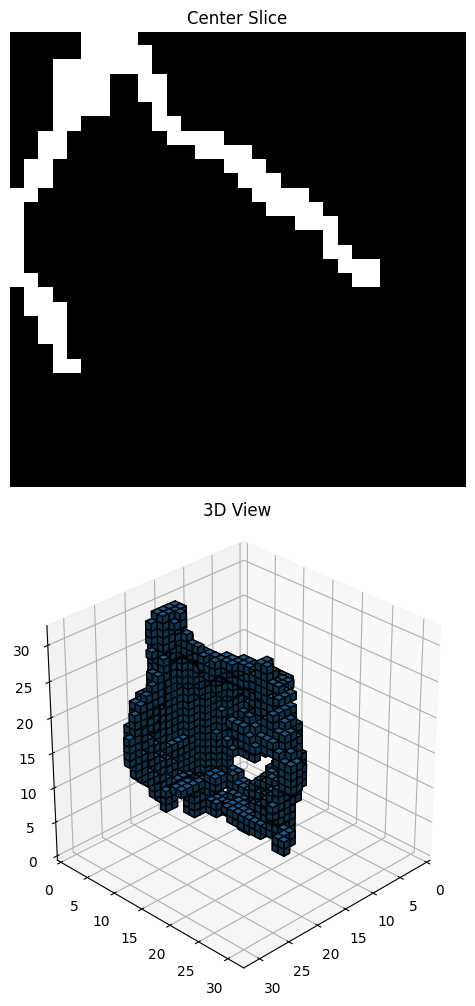

In [19]:
inferencer.visualize_samples(samples, threshold=0.5)

Stage 1: Generating shapes...



ampling Steps: 100%|███████████████████████| 1000/1000 [02:30<00:00,  6.63it/s]


Shape stage completed. Visualization:

Shape occupancy: 3031 voxels (9.25%)


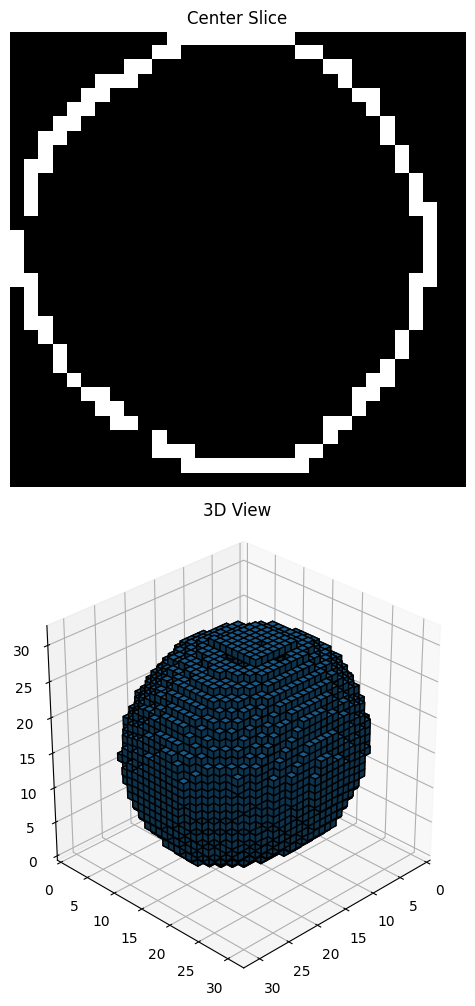


Stage 2: Adding colors...



olor Sampling: 100%|███████████████████████| 1000/1000 [02:30<00:00,  6.63it/s]

In [44]:
samples = inferencer.sample_two_stage(
        prompt="green sphere",
        num_samples=1,
        image_size=(32, 32, 32),
        guidance_scale=12.0,
        color_guidance_scale=10.0,
        show_after_shape=True,
        use_rotations=False, 
        use_mean_init=False
    )


Sample Statistics:
Occupancy:
- Total voxels: 32768
- Occupied voxels: 3031 (9.25%)

Color Statistics (occupied voxels):

Red Channel:
- Range: [0.000, 0.713]
- Mean: 0.277
- Std: 0.084

Green Channel:
- Range: [0.000, 0.632]
- Mean: 0.322
- Std: 0.070

Blue Channel:
- Range: [0.000, 0.604]
- Mean: 0.194
- Std: 0.082

Overall RGB Statistics:
- Mean intensity: 0.264
- Color variance: 0.095

Color Distribution:
- Dominant Red: 1.2%
- Dominant Green: 0.7%
- Dominant Blue: 0.5%


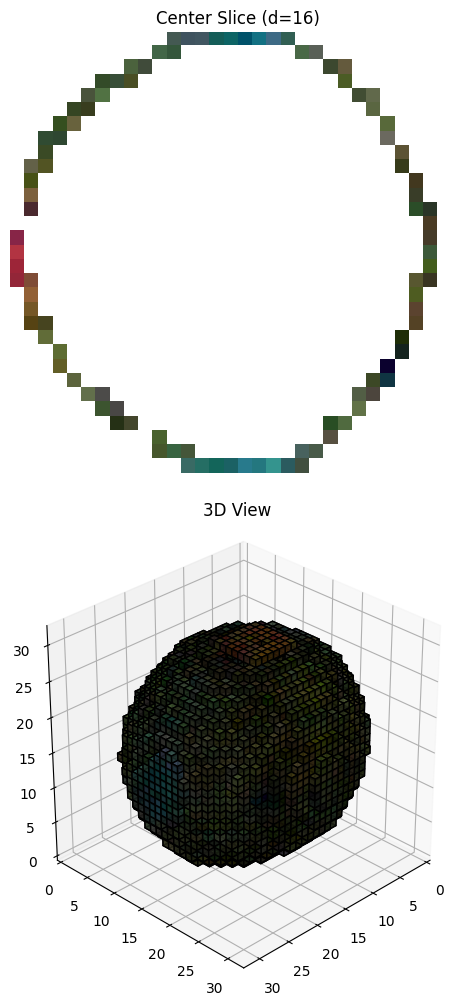

In [45]:
inferencer.visualize_samples(samples, threshold=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of vertices: 27160
Max face index: 27159
Number of faces: 74690


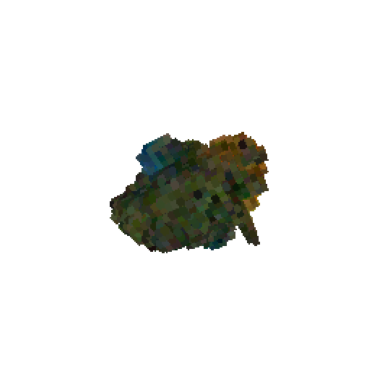

In [14]:
inferencer.visualize_samples_p3d(samples[0], threshold=0.5)

RGB range: [0.000, 0.922]
Alpha range: [0.000, 1.000]
Occupied voxels: 890 (2.72% of volume)


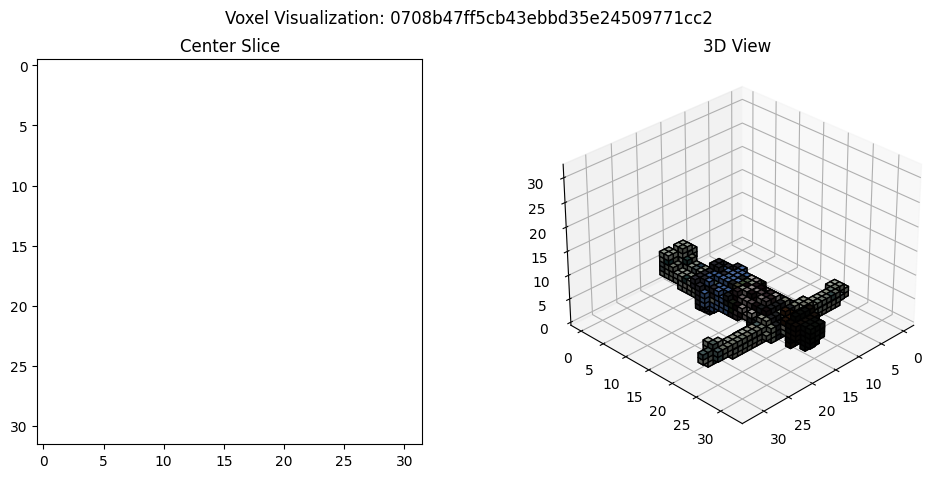

In [6]:
from blockgen.utils import plot_voxel_tensor

plot_voxel_tensor("/scratch/students/2024-fall-sp-pabdel/3D-BlockGen/objaverse_data_voxelized/hf-objaverse-v1/glbs/000-035/0708b47ff5cb43ebbd35e24509771cc2.pt")

In [ ]:
from datasets import load_dataset

dataset = load_dataset("PeterAM4/blockgen-3d")
print("Train size:", len(dataset['train']))
print("Test size:", len(dataset['test']))
